In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
#for the first time, you should not run this block
#after data processed and saved, you can run this block and then
#jump to "from sklearn import preprocessing" for statistical learning and
#jump to X_train = torch.tensor(X_train, dtype=torch.float32).to(device) for deep learning
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(20000, 30) (5000, 30)
(20000,) (5000,)


In [7]:
read_rows = 250000000 #the dataset is too big so only choose part of it
rows = 10000 # 10000 data compress to one data point
data = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows=read_rows)

<function matplotlib.pyplot.show(close=None, block=None)>

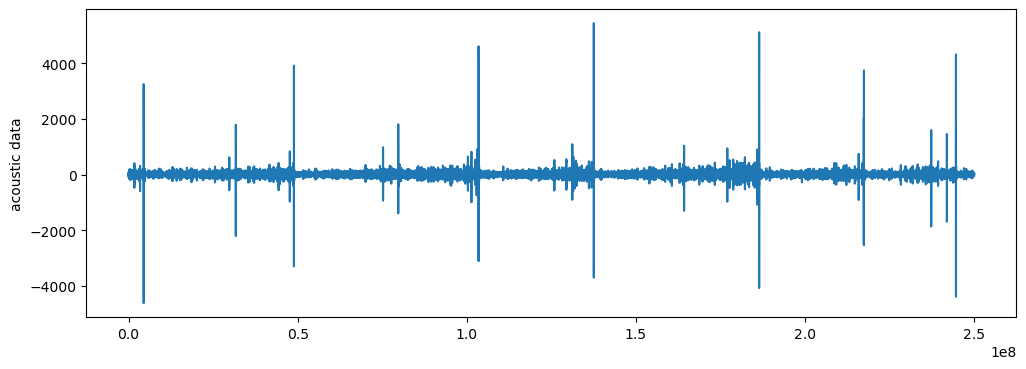

In [8]:
XX = np.array(data['acoustic_data'])
yy = np.array(data['time_to_failure'])
plt.plot(XX)
plt.rcParams['figure.figsize']=(12.0,4.0)
plt.ylabel("acoustic data")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

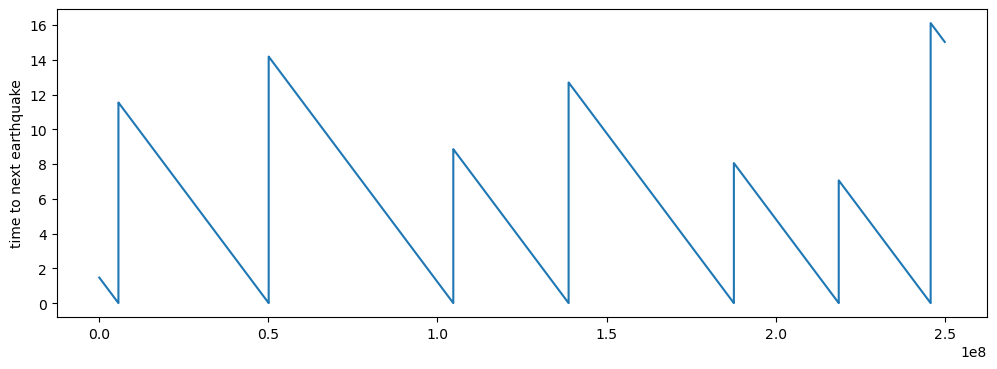

In [9]:
plt.plot(yy)
plt.rcParams['figure.figsize']=(12.0,4.0)
plt.ylabel("time to next earthquake")
plt.show

In [6]:
from sklearn.linear_model import LinearRegression

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def featuresx(x_data, X, segment):
    X.loc[segment, 'ave'] = x_data.mean()
    X.loc[segment, 'std'] = x_data.std()
    X.loc[segment, 'max'] = x_data.max()
    X.loc[segment, 'min'] = x_data.min()
    X.loc[segment, 'q01'] = np.quantile(x_data,0.01)
    X.loc[segment, 'q05'] = np.quantile(x_data,0.05)
    X.loc[segment, 'q95'] = np.quantile(x_data,0.95)
    X.loc[segment, 'q99'] = np.quantile(x_data,0.99)
    
    X.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x_data))
    X.loc[segment, 'mean_change_rate'] = calc_change_rate(x_data)
    X.loc[segment, 'abs_max'] = np.abs(x_data).max()
    X.loc[segment, 'abs_min'] = np.abs(x_data).min()

    X.loc[segment, 'max_to_min'] = x_data.max() / np.abs(x_data.min())
    X.loc[segment, 'max_to_min_diff'] = x_data.max() - np.abs(x_data.min())
    X.loc[segment, 'count_big'] = len(x_data[np.abs(x_data) > 500])
    X.loc[segment, 'sum'] = x_data.sum()

    X.loc[segment, 'abs_trend'] = add_trend_feature(x_data, abs_values=True)
    X.loc[segment, 'abs_mean'] = np.abs(x_data).mean()
    X.loc[segment, 'abs_std'] = np.abs(x_data).std()
    X.loc[segment, 'abs_median'] = np.median(np.abs(x_data))
    
    X.loc[segment, 'trend'] = add_trend_feature(x_data)
    X.loc[segment, 'mad'] = stats.median_abs_deviation(x_data)
    X.loc[segment, 'kurt'] = x_data.kurtosis()
    X.loc[segment, 'skew'] = x_data.skew()
    X.loc[segment, 'med'] = x_data.median()
    
    X.loc[segment, 'abs_q95'] = np.quantile(np.abs(x_data),0.95)
    X.loc[segment, 'abs_q99'] = np.quantile(np.abs(x_data),0.99)
    X.loc[segment, 'F_test'], X.loc[segment, 'p_test'] = stats.f_oneway(x_data[:2000],x_data[2000:4000],x_data[4000:6000],x_data[6000:8000],x_data[8000:])
    X.loc[segment, 'av_change_abs'] = np.mean(np.diff(x_data))
        
    return X

def feature_extraction(data,segments):
    X = pd.DataFrame(index=range(segments), dtype=np.float64)
    y = pd.DataFrame(index=range(segments), dtype=np.float64,columns=['time_to_failure'])
    for segment in range(segments):
        if segment % 1000 == 0 and segment != 0:
            print("feature extraction segment ", segment)
        seg = data.iloc[segment*rows:segment*rows+rows]
        x_data = pd.Series(seg['acoustic_data'].values)
        y_data = seg['time_to_failure'].values[-1]

        y.loc[segment,'time_to_failure'] = y_data
        
        X = featuresx(x_data, X, segment)
        
    return X, y

In [7]:
segments = int(np.floor(data.shape[0] / rows))
print(segments)

X,y = feature_extraction(data, segments)

y=y.values.flatten()
print(X.shape)
print(y.shape)

25000
feature extraction segment  1000
feature extraction segment  2000
feature extraction segment  3000
feature extraction segment  4000
feature extraction segment  5000
feature extraction segment  6000
feature extraction segment  7000
feature extraction segment  8000
feature extraction segment  9000
feature extraction segment  10000
feature extraction segment  11000
feature extraction segment  12000
feature extraction segment  13000
feature extraction segment  14000
feature extraction segment  15000
feature extraction segment  16000
feature extraction segment  17000
feature extraction segment  18000
feature extraction segment  19000
feature extraction segment  20000
feature extraction segment  21000
feature extraction segment  22000
feature extraction segment  23000
feature extraction segment  24000
(25000, 30)
(25000,)


In [ ]:
#save data for the first time
X_train = np.array(X[:20000])
X_val = np.array(X[20000:])
y_train = np.array(y[:20000])
y_val = np.array(y[20000:])
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)

In [5]:
#jump here for statistical learning
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_new = scaler.transform(X_train)
X_val_new = scaler.transform(X_val)

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_new, y_train)
predictions=model.predict(X_val_new)
score=model.score(X_val_new, y_val)
print(score)
mse = mean_squared_error(y_val, predictions)
print(mse)

0.02810775484774819
14.783105850407674


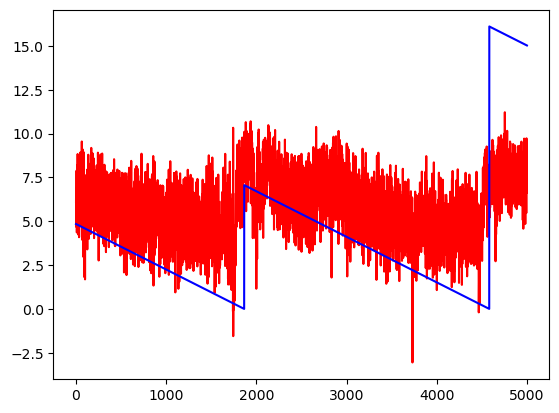

In [ ]:
plt.plot(predictions, c="r")
plt.plot(y_val, c="b")
plt.show()

0.012209892017803203
15.024922564331058


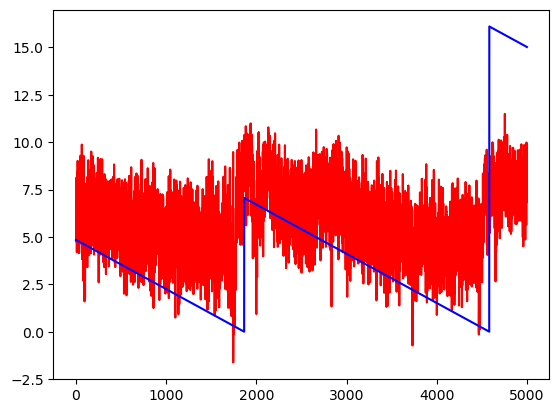

In [ ]:
from sklearn.svm import NuSVR
model = NuSVR(kernel='linear')
model.fit(X_train_new, y_train)
predictions=model.predict(X_val_new)
score=model.score(X_val_new, y_val)
print(score)
mse = mean_squared_error(y_val, predictions)
print(mse)
plt.plot(predictions, c="r")
plt.plot(y_val, c="b")
plt.show()

0.06623947158858112
14.203097924992868


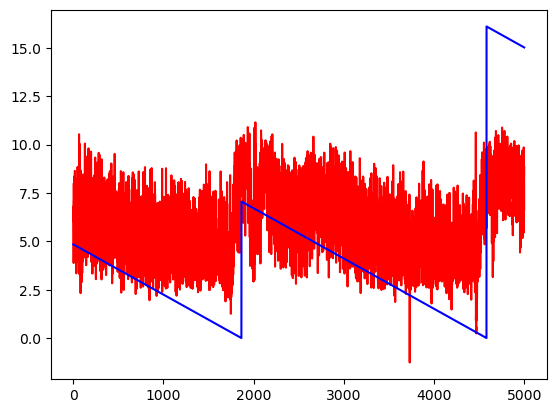

In [6]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(64,))
model.fit(X_train_new, y_train)
predictions=model.predict(X_val_new)
score=model.score(X_val_new, y_val)
print(score)
mse = mean_squared_error(y_val, predictions)
print(mse)
plt.plot(predictions, c="r")
plt.plot(y_val, c="b")
plt.show()

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, layer_dim=1, output_dim=1, dropout_prob=0.5):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden_prev):
        '''print(x.dtype, hidden_prev.dtype)
        for p in self.rnn.parameters():
            print(p.dtype)'''
        out, hidden_prev = self.rnn(x, hidden_prev)        
        out = self.fc(out)
        return out, hidden_prev


In [9]:
hidden_dim = 16
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim)
#test model input and output
o, h = model(torch.randn((1, 30)), torch.randn((1, hidden_dim)))
print(o)
print(h.shape)
model.to(device)

d:\ProgramData\Anaconda3\envs\mydl\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


tensor([[0.6336]], grad_fn=<AddmmBackward0>)
torch.Size([1, 16])


RNNModel(
  (rnn): RNN(30, 16, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [10]:
lr = 0.01
print_iter = 2000
train_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
hidden_prev = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)

for i in range(len(X_train)):
    loss_sum = 0.0
    x_training = X_train[i].reshape((1, -1))
    output, hidden_prev = model(x_training, hidden_prev)
    hidden_prev = hidden_prev.detach()
    loss = criterion(output, y_train[i].reshape((1,-1)))
    loss_sum += loss.item()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_iter == 0:
        print("Iteration: {} loss {}".format(i, loss_sum / print_iter))
        train_losses.append(loss_sum / print_iter)
        loss_sum = 0.0
        


Iteration: 0 loss 0.0009141286611557007
Iteration: 2000 loss 3.540798206813633e-08
Iteration: 4000 loss 5.6689696066314354e-09
Iteration: 6000 loss 5.58680112590082e-08
Iteration: 8000 loss 6.918480721651576e-09
Iteration: 10000 loss 8.746711728235823e-10
Iteration: 12000 loss 1.2486270861700177e-08
Iteration: 14000 loss 4.277855041436851e-07
Iteration: 16000 loss 1.2491036613937468e-08
Iteration: 18000 loss 1.937032720888965e-09


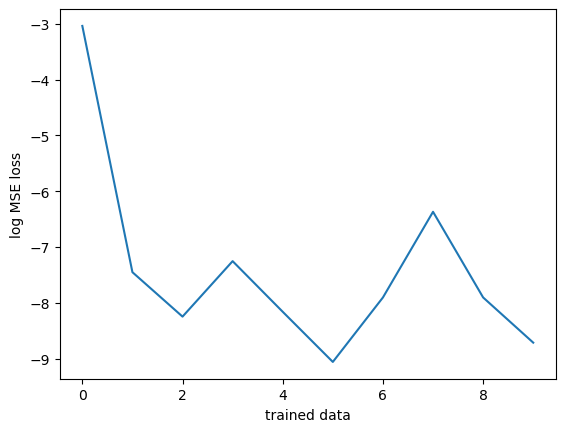

In [11]:
plt.plot(np.log10(train_losses))
plt.xlabel("trained data")
plt.ylabel("log MSE loss")
plt.show()

In [12]:
yhat = []
with torch.no_grad():
    train_hidden_prev = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)
    model.eval()
    for i in range(len(X_val)):
        x_t = X_val[i].reshape((1, -1))
        output, train_hidden_prev = model(x_t, train_hidden_prev)
        yhat.append(output.cpu().numpy()[0][0])
        if i % 5000 == 0:
            print(i)
print(len(yhat))

0
5000


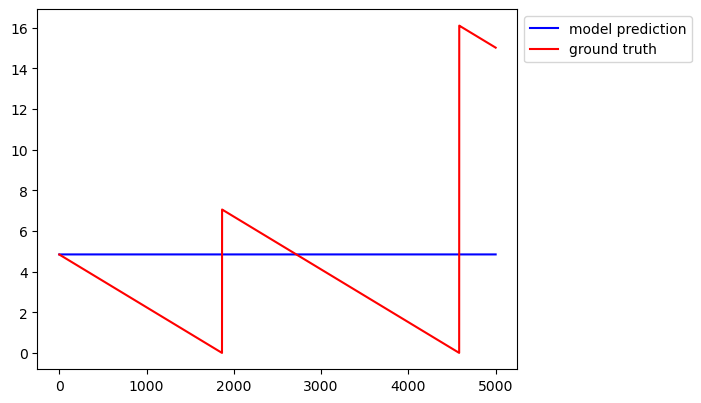

In [13]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,0.75,0.75])
ax1.plot(yhat, c="b", label="model prediction")
ax1.plot(y_val.cpu(), c="r", label="ground truth")
ax1.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()

In [14]:
for p in model.rnn.parameters():
    print(p)

Parameter containing:
tensor([[ 9.4914e-02,  4.3483e-02, -1.8791e-01,  8.4462e-02, -8.4399e-02,
         -1.6079e-01, -1.4764e-02,  1.9760e-01, -1.5564e-02,  4.8385e-02,
         -1.4233e-02, -1.4309e-01,  3.1487e-02, -2.0060e-02, -1.0166e-01,
         -1.4836e-01, -3.7805e-02, -1.3692e-01, -1.1838e-01, -7.1729e-02,
          5.1346e-02,  2.1148e-02,  8.0952e-02, -1.0315e-01,  5.0261e-02,
          6.9683e-02,  1.5969e-01, -7.5838e-02,  6.7539e-02,  2.0631e-01],
        [-1.5922e-01, -1.6282e-01, -4.8455e-02, -7.4077e-02, -4.8178e-02,
          8.0147e-02,  2.0286e-02,  1.3556e-01,  1.1997e-01, -4.6563e-02,
          1.8014e-01, -2.9251e-02, -4.1800e-02,  1.0519e-01,  2.9014e-01,
         -1.7369e-01, -4.7647e-02, -5.7656e-02, -5.1745e-02, -8.2777e-02,
         -1.0546e-01,  9.4909e-02, -6.6233e-02, -7.2356e-02, -7.6834e-02,
          8.9949e-02, -2.5769e-03,  1.0824e-01,  9.9002e-02, -1.1757e-01],
        [ 2.8484e-02, -1.6425e-01, -5.1674e-03,  3.6495e-03, -6.3300e-02,
         -1.74

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, layer_dim=1, output_dim=1, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.rnn = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.001)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden_prev):
        '''print(x.dtype, hidden_prev.dtype)
        for p in self.rnn.parameters():
            print(p.dtype)'''
        out, hidden_prev = self.rnn(x, hidden_prev)        
        out = self.fc(out)
        return out, hidden_prev

In [14]:
lstm_model = LSTMModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim)
#test model input and output
o, (h, c) = lstm_model(torch.randn((1, X_train.shape[1])), (torch.randn((1, hidden_dim)), torch.randn((1, hidden_dim))))
print(o)
print(h.shape, c.shape)
lstm_model.to(device)

tensor([[-0.2917]], grad_fn=<AddmmBackward0>)
torch.Size([1, 16]) torch.Size([1, 16])


d:\ProgramData\Anaconda3\envs\mydl\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMModel(
  (rnn): LSTM(30, 16, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [15]:
lr = 0.01
print_iter = 2000
train_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr)
hhh = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)
ccc = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)

for i in range(len(X_train)):
    loss_sum = 0.0
    x_training = X_train[i].reshape((1, -1))
    output, (hhh, ccc) = lstm_model(x_training, (hhh, ccc))
    hhh = hhh.detach()
    ccc = ccc.detach()
    loss = criterion(output, y_train[i].reshape((1,-1)))
    loss_sum += loss.item()
    lstm_model.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_iter == 0:
        print("Iteration: {} loss {}".format(i, loss_sum / print_iter))
        train_losses.append(loss_sum / print_iter)
        loss_sum = 0.0
        

Iteration: 0 loss 0.0010462898015975953
Iteration: 2000 loss 4.64614131487906e-07
Iteration: 4000 loss 5.874696944374591e-08
Iteration: 6000 loss 7.568051223643124e-07
Iteration: 8000 loss 1.0001882765209302e-07
Iteration: 10000 loss 1.4133831427898258e-08
Iteration: 12000 loss 1.1900525714736432e-07
Iteration: 14000 loss 7.195418584160507e-07
Iteration: 16000 loss 1.6887141100596635e-07
Iteration: 18000 loss 2.2519601770909502e-08


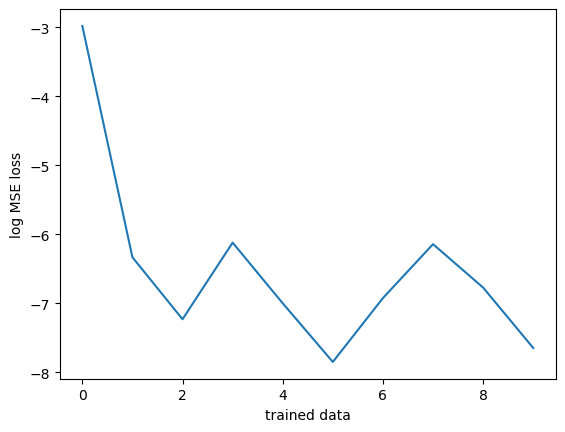

In [16]:
plt.plot(np.log10(train_losses))
plt.xlabel("trained data")
plt.ylabel("log MSE loss")
plt.show()

In [18]:
yhat = []
with torch.no_grad():
    hhh = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)
    ccc = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)
    lstm_model.eval()
    for i in range(len(X_val)):
        x_t = X_val[i].reshape((1, -1))
        output, (hhh, ccc) = lstm_model(x_t, (hhh, ccc))
        yhat.append(output.cpu().numpy()[0][0])
        if i % 5000 == 0:
            print(i)
print(len(yhat))

0
5000


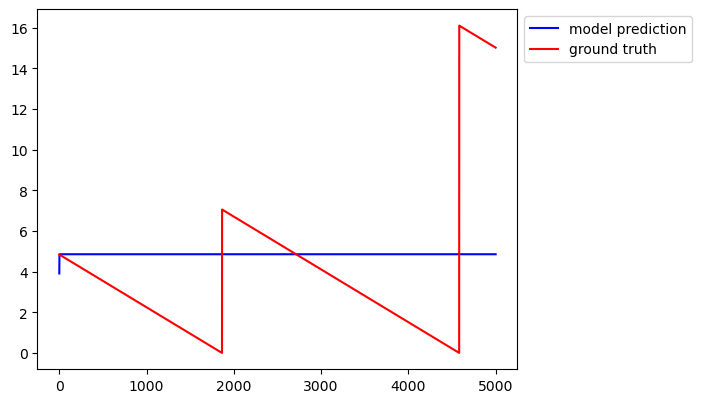

In [20]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,0.75,0.75])
ax1.plot(yhat, c="b", label="model prediction")
ax1.plot(y_val.cpu(), c="r", label="ground truth")
ax1.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()

In [23]:
#load data again
X_train = X_train.reshape((-1, 300))
X_val = X_val.reshape((-1, 300))
y_train = y_train[::10]
y_val = y_val[::10]
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(2000, 300) (500, 300)
(2000,) (500,)


In [26]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

In [24]:
hidden_dim = 32
model = RNNModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim)
#test model input and output
o, h = model(torch.randn((1, 300)), torch.randn((1, hidden_dim)))
print(o)
print(h.shape)
model.to(device)

tensor([[0.1060]], grad_fn=<AddmmBackward0>)
torch.Size([1, 32])


d:\ProgramData\Anaconda3\envs\mydl\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNNModel(
  (rnn): RNN(300, 32, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [27]:
lr = 0.01
print_iter = 2000
train_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
hidden_prev = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)

for i in range(len(X_train)):
    loss_sum = 0.0
    x_training = X_train[i].reshape((1, -1))
    output, hidden_prev = model(x_training, hidden_prev)
    hidden_prev = hidden_prev.detach()
    loss = criterion(output, y_train[i].reshape((1,-1)))
    loss_sum += loss.item()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_iter == 0:
        print("Iteration: {} loss {}".format(i, loss_sum / print_iter))
        train_losses.append(loss_sum / print_iter)
        loss_sum = 0.0

Iteration: 0 loss 0.0010815098285675048


0


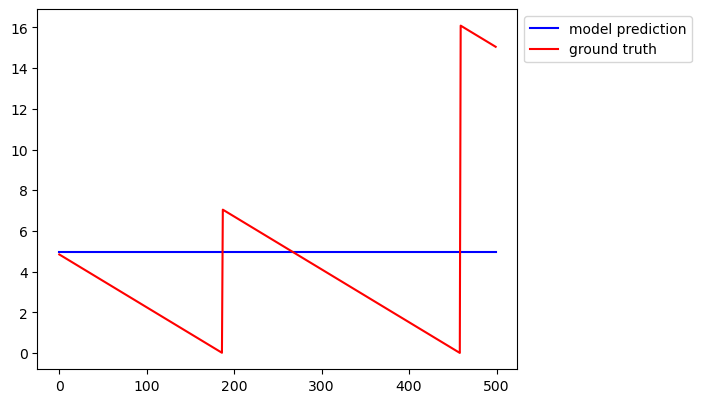

In [28]:
yhat = []
with torch.no_grad():
    train_hidden_prev = torch.zeros((1, hidden_dim), dtype=torch.float32).to(device)
    model.eval()
    for i in range(len(X_val)):
        x_t = X_val[i].reshape((1, -1))
        output, train_hidden_prev = model(x_t, train_hidden_prev)
        yhat.append(output.cpu().numpy()[0][0])
        if i % 5000 == 0:
            print(i)
fig = plt.figure()
ax1 = fig.add_axes([0,0,0.75,0.75])
ax1.plot(yhat, c="b", label="model prediction")
ax1.plot(y_val.cpu(), c="r", label="ground truth")
ax1.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()